# EE-411 Fundamentals of inference and learning

## Exercise session 13: Denoising & Variational Autoencoders

**What you will learn today:** In this notebook, we will learn the basics of denoising and generative models. We consider two important architectures: denoising autoencoders & variational autoencoders. In the bonus section at the end you will find amazing tutorials on Diffusion Models!

Take MNIST, try to creat autoencoders, run it 

autoencoders = reconstruct the image, 

input -> Encoder -> Decoder 

X E R^d    //         Y E R^d             

goal of encoder find a low dim representation of the data, Noisy Image -> Encoder (Denoising Autoencoder) Input with noise and then goal output output without noise (In 7 Noisy -> 7 without Noise)

## Denoising with auto-encoders

As usual we consider our favourit (and easiest to run) MNIST dataset. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import os 
import math
## torch imports ##
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [22]:
# define the hyperparameters
BATCH_SIZE = 64
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01
EPOCHS = 40
# choose MSE loss
LOSS = nn.MSELoss()
# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


We will use only a small portion of MNIST for this tutorial as we the qualitative claims will be left unchanged. 


Let's load the dataset and create the dataloader.

In [3]:
transform = torchvision.transforms.ToTensor()

# load the train dataset

## use only 30% of the dataset for training ##
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_dataset, _ = random_split(train_dataset, [int(len(train_dataset)*0.1), int(len(train_dataset)*0.9)])

# load the test dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# create the data loaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

2.3%

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



55.6%

100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



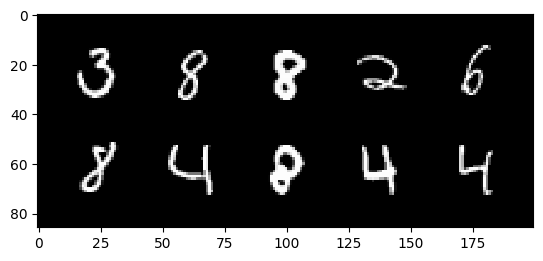

In [4]:
def visualize_images(dataloader):
    images = next(iter(dataloader))[0][:10]
    grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

    def show(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")

    show(grid)

visualize_images(train_dataloader)

### Creating the denoising autoencoder

In [5]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(1568, 128),
            nn.ReLU(True),
            nn.Linear(128, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 1568),
            nn.ReLU(True),
            nn.Unflatten(1, (32, 7, 7)),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)
        return decoded


### Initialize models, loss, parameters

In [6]:
# Instantiate the Denoising Autoencoder model
latent_dim = 32 
denoising_autoencoder = DenoisingAutoencoder(latent_dim)
# Define the optimizer
params_to_optimize = denoising_autoencoder.parameters()
optim = torch.optim.Adam(params_to_optimize, lr = LEARNING_RATE)
# Train the model
denoising_autoencoder.to(DEVICE)

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1568, out_features=128, bias=True)
    (10): ReLU(inplace=True)
    (11): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1568, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(di

### Training

Introducing the clipping procedure to create the corrupted images.

In [7]:
### function to add a given noise_factor to the image ###
def corruption(img,noise_factor):
     noisy_img = img + torch.randn_like(img)*noise_factor
     noisy_img = torch.clip(noisy_img, 0., 1.)
     return noisy_img

In [8]:
### appply encoder to check shapes of one image ###
img = next(iter(train_dataloader))[0][0]
img = img.to(DEVICE)
img = img.unsqueeze(0)
print(img.shape)
encoded_img = denoising_autoencoder.encoder(img)
print(encoded_img.shape)
decoded_img = denoising_autoencoder.decoder(encoded_img)
print(decoded_img.shape)


torch.Size([1, 1, 28, 28])
torch.Size([1, 32])
torch.Size([1, 1, 28, 28])


#### Your turn
Try to write the training epoch function for a denoising autoencoder. Remember, what we are trying to learn is not anymore the label itself, but the image starting from a noisy version of it! In other words, we are trying to reconstruct! Look at the function we used last time in *training_utils.py*, it will help!

In [10]:
# write training_epoch function for denoising autoencoder
def training_epoch(denoising_autoencoder, device, dataloader, loss_func, optimizer, noise_factor):
    denoising_autoencoder.train()
    train_loss = []
    for image_batch, _ in dataloader: 
        ### your code here ### 
        image_batch = image_batch.to(device)
        noisy_image_batch = corruption(image_batch,noise_factor)
        optimizer.zero_grad()
        output = denoising_autoencoder(noisy_image_batch)
        loss = loss_func(output,image_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        
    return np.mean(train_loss)

Epoch: 1 	Training Loss: 0.012100


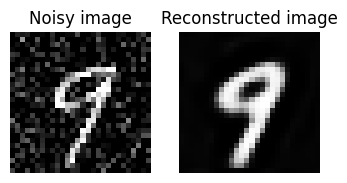

Epoch: 2 	Training Loss: 0.011824
Epoch: 3 	Training Loss: 0.011503
Epoch: 4 	Training Loss: 0.011345
Epoch: 5 	Training Loss: 0.011197
Epoch: 6 	Training Loss: 0.011141


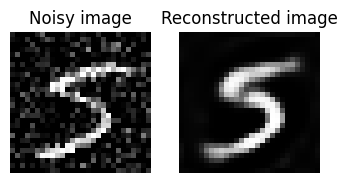

Epoch: 7 	Training Loss: 0.010920
Epoch: 8 	Training Loss: 0.010687
Epoch: 9 	Training Loss: 0.010530
Epoch: 10 	Training Loss: 0.010457
Epoch: 11 	Training Loss: 0.010142


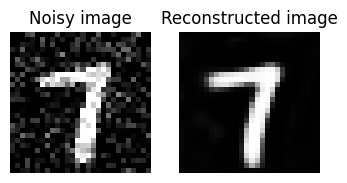

Epoch: 12 	Training Loss: 0.010040
Epoch: 13 	Training Loss: 0.009997
Epoch: 14 	Training Loss: 0.009937
Epoch: 15 	Training Loss: 0.009726
Epoch: 16 	Training Loss: 0.009567


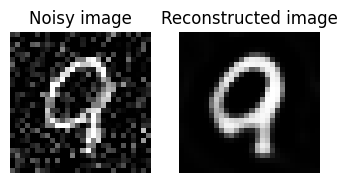

Epoch: 17 	Training Loss: 0.009593
Epoch: 18 	Training Loss: 0.009349
Epoch: 19 	Training Loss: 0.009413
Epoch: 20 	Training Loss: 0.009342
Epoch: 21 	Training Loss: 0.009191


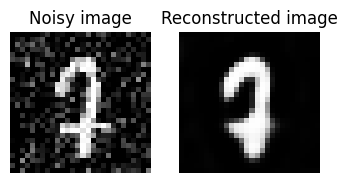

Epoch: 22 	Training Loss: 0.009092
Epoch: 23 	Training Loss: 0.008948
Epoch: 24 	Training Loss: 0.008924
Epoch: 25 	Training Loss: 0.008993
Epoch: 26 	Training Loss: 0.008727


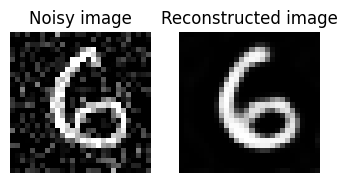

Epoch: 27 	Training Loss: 0.008708
Epoch: 28 	Training Loss: 0.008855
Epoch: 29 	Training Loss: 0.008624
Epoch: 30 	Training Loss: 0.008567
Epoch: 31 	Training Loss: 0.008558


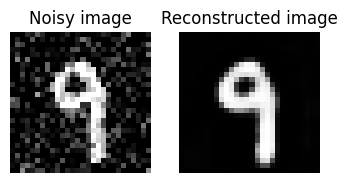

Epoch: 32 	Training Loss: 0.008599
Epoch: 33 	Training Loss: 0.008404
Epoch: 34 	Training Loss: 0.008343
Epoch: 35 	Training Loss: 0.008406
Epoch: 36 	Training Loss: 0.008346


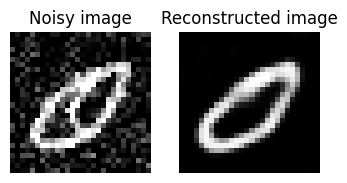

Epoch: 37 	Training Loss: 0.008240
Epoch: 38 	Training Loss: 0.008269
Epoch: 39 	Training Loss: 0.008176
Epoch: 40 	Training Loss: 0.008058


In [23]:
noise_factor = 0.2
for epoch in range(EPOCHS):
    train_loss = training_epoch(denoising_autoencoder, DEVICE, train_dataloader, LOSS, optim, noise_factor)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))
    if epoch % 5 == 0:
        # plot the noisy image and the reconstructed one for 5 images of the training set 
        img = next(iter(train_dataloader))[0][0]
        img = img.unsqueeze(0)
        img_noisy = corruption(img, noise_factor)
        img_noisy = img_noisy.to(DEVICE)
        img_reconstructed = denoising_autoencoder(img_noisy)
        ### plot the noisy image and the reconstructed one for one image of the training set with small figure size ###
        plt.figure(figsize=(4,2))
        plt.subplot(1,2,1)
        plt.imshow(img_noisy.squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.title('Noisy image')
        plt.subplot(1,2,2)
        plt.imshow(img_reconstructed.squeeze().detach().cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed image')
    
        plt.show()


### Studying the latent space of a denoising autoencoder 

After the encoding step we obtain a *low-dimensional* representation of our dataset. This low-dimensional space is called *latent space*. Let us analyze with the different tools of the previous lectures this low-dimensional subspace. 

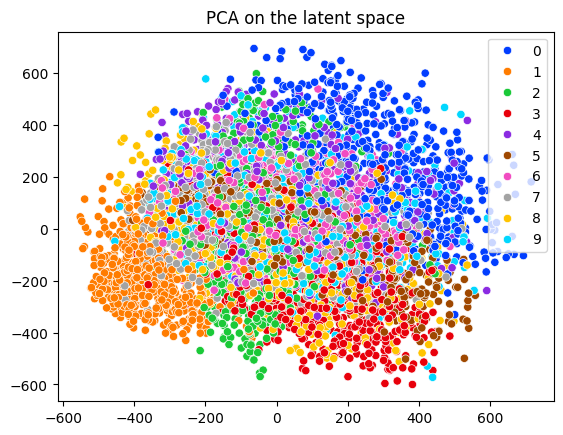

In [12]:
### perform PCA on the latent space of the autoencoder visualizing with color labels for different digits ###
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

def plot_latent_space(model, device, dataloader):
    model.eval()
    latent_vectors = []
    labels = []
    for image_batch, label_batch in dataloader:
        image_batch = image_batch.to(device)
        latent_vector = model.encoder(image_batch).detach().cpu().numpy()
        latent_vectors.append(latent_vector)
        labels.append(label_batch.numpy())
    latent_vectors = np.concatenate(latent_vectors)
    labels = np.concatenate(labels)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_vectors)
    sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 10))
    plt.title('PCA on the latent space')
    plt.show()
    return pca_result

pca_result = plot_latent_space(denoising_autoencoder, DEVICE, train_dataloader)

We can grasp a clustered structure but it is not satisfying. Let us try some non-linear dimensionality reduction tool, e.g., t-SNE. 

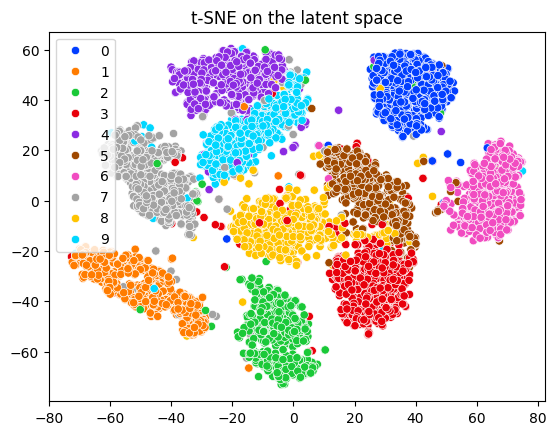

In [13]:
### perform the same using t-SNE ### 

def plot_latent_space_tsne(model, device, dataloader):
    model.eval()
    latent_vectors = []
    labels = []
    for image_batch, label_batch in dataloader:
        image_batch = image_batch.to(device)
        latent_vector = model.encoder(image_batch).detach().cpu().numpy()
        latent_vectors.append(latent_vector)
        labels.append(label_batch.numpy())
    latent_vectors = np.concatenate(latent_vectors)
    labels = np.concatenate(labels)
    tsne = TSNE(n_components=2)
    tsne_result = tsne.fit_transform(latent_vectors)
    sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 10))
    plt.title('t-SNE on the latent space')
    plt.show()
    return tsne_result

tsne_result = plot_latent_space_tsne(denoising_autoencoder, DEVICE, train_dataloader)


We see that with more sophisticated unsupervised learning strategy we are able to recognize groups according to the different digits! An interesting direction to explore is to analyze what happens when we enforce a certain structure on the latent space **during training**. This is the topic of Variational Autoencoders detailed in the next section. 

## Variational auto-encoders

We introduce the Variational AutoeEncoder (VAE) introduced by Kingma and Welling [https://arxiv.org/abs/1312.6114]. A great tutorial by the same authors is https://arxiv.org/pdf/1906.02691.pdf, we will refer to it a lot over the course of the tutorial and it is very clearly explained for those of you who are interested to dig deeper into the developement of this interesting topic.
We need first to introduce the new architecture that manages to enforce a Gaussian structure in the latent space by using a clever *reparametrization trick*.


In [14]:
class ConvVAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(ConvVAE, self).__init__()

        self.latent_dim = latent_dim
        self.input_dim = input_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(1568, 128),
            nn.ReLU(True),
            nn.Linear(128, 2*latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 1568),
            nn.ReLU(True),
            nn.Unflatten(1, (32, 7, 7)),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        enc_output = self.encoder(x)
        mu, logvar = torch.chunk(enc_output, 2, dim=1)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Decode
        dec_output = self.decoder(z)

        return dec_output, mu, logvar

During training we update the Gaussian parameters describing our latent space $(\mu, \log{\Delta})$. We avoid a stochastic node that would create problem during backprop using the function *reparametrize*.

We are ready to procede with the training of this VAE.

In [15]:
LEARNING_RATE = 0.001
EPOCHS = 20
latent_dim = 100
# Instantiate the Convolutional VAE model
model = ConvVAE(input_dim = 784, latent_dim = latent_dim)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [16]:
def loss_function(x, x_hat, mean, log_var):
    # Reconstruction loss (negative log likelihood)
    reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')

    # KL divergence
    kl_divergence = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    # Total loss
    total_loss = reconstruction_loss + kl_divergence

    return total_loss

In [17]:
### perform training ### 
for epoch in range(EPOCHS):
    for data in train_dataloader:
        inputs, _ = data
        inputs = inputs.to(DEVICE)
        
        optimizer.zero_grad()

        recon_batch, mu, log_var = model(inputs)
        loss = loss_function(inputs, recon_batch, mu, log_var)

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item()}')


Epoch 1/20, Loss: 22486.4921875
Epoch 2/20, Loss: 19903.525390625
Epoch 3/20, Loss: 18881.501953125
Epoch 4/20, Loss: 17609.419921875
Epoch 5/20, Loss: 16514.2421875
Epoch 6/20, Loss: 15871.0458984375
Epoch 7/20, Loss: 15192.16015625
Epoch 8/20, Loss: 14123.2734375
Epoch 9/20, Loss: 13537.1484375
Epoch 10/20, Loss: 12590.7451171875
Epoch 11/20, Loss: 12324.5703125
Epoch 12/20, Loss: 11964.935546875
Epoch 13/20, Loss: 11701.08203125
Epoch 14/20, Loss: 10784.05078125
Epoch 15/20, Loss: 10619.1533203125
Epoch 16/20, Loss: 10207.947265625
Epoch 17/20, Loss: 10177.15234375
Epoch 18/20, Loss: 9779.1669921875
Epoch 19/20, Loss: 9866.607421875
Epoch 20/20, Loss: 8957.7158203125


In [18]:
def digit_generation(model, device, num_samples=1):
    model.eval()
    with torch.no_grad():
        # Sample from the standard normal distribution
        z_sample = torch.randn(num_samples, model.latent_dim).to(device)
        # Decode the samples to generate new digits
        generated_digits = model.decoder(z_sample)

    return generated_digits
def plot_generated_digits(generated_digits, num_samples=5, figsize=(10, 2)):
    plt.figure(figsize=figsize)
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        img = generated_digits[i].cpu().squeeze().detach().numpy() 
        ### reshape to 28x28
        img = np.reshape(img,(28,28))
        plt.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

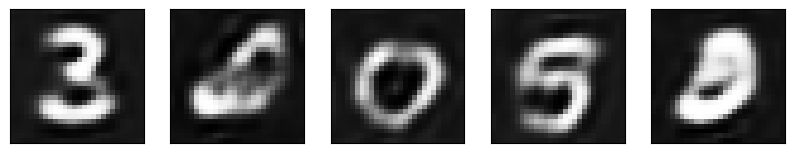

torch.Size([5, 1, 28, 28])


In [19]:
# Example usage:
generated_digits = digit_generation(model, device = DEVICE, num_samples=5)
plot_generated_digits(generated_digits)
print(generated_digits.shape)

Our hope is that after training the latent space will encode efficiently relationship between different images.

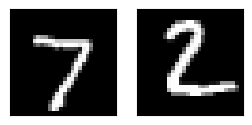

In [20]:
## choose two random images and plot them ##
img1 = test_dataset[0][0].unsqueeze(0)
img2 = test_dataset[1][0].unsqueeze(0)
plt.figure(figsize=(3,1.5))
ax = plt.subplot(1,2,1)
plt.imshow(img1.cpu().squeeze().numpy(), cmap='gist_gray')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1,2,2)
plt.imshow(img2.cpu().squeeze().numpy(), cmap='gist_gray')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

What does it look like an image that is generated as a linear interpolation of this two in latent space? 

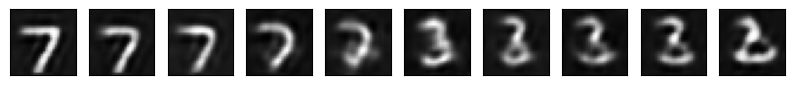

In [21]:
### interpolate between the two images ###
# encode the two images
img1 = img1.to(DEVICE)
img2 = img2.to(DEVICE)
enc_output1 = model.encoder(img1)
mu1, logvar1 = torch.chunk(enc_output1, 2, dim=1)
enc_output2 = model.encoder(img2)
mu2, logvar2 = torch.chunk(enc_output2, 2, dim=1)
# create the interpolation
generated_digits = []
for i in range(10):
    ### linear interpolation of the means
    mean_interp = mu1 + (mu2-mu1)*i/10
    ### fix the logvar to be the one of the first image
    logvar_interp = logvar1
    z = model.reparameterize(mean_interp, logvar_interp)
    ### generate the images
    generated_digits.append(model.decoder(z))
plot_generated_digits(generated_digits, num_samples=10, figsize=(10, 1))
plt.show()

## Bonus - Diffusion models: 

If you want to explore modern generative models in which denoising plays a pivotal role (Denoising Diffusion Models) check out these amazing resources. They are guided step-by-step. (License information in the repositories).
- https://nn.labml.ai/diffusion/ddpm/index.html
- https://github.com/acids-ircam/diffusion_models (both in JAX and Pythorch!)